In [1]:
import re
import torch
from torch import nn
import numpy as np
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import vocab as Vocab
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict

torch.manual_seed(123)

In [2]:
class PEmbedding(nn.Module):
    def __init__(self, vocab, emb, pad, sent_max=500, p=0.1):
        super().__init__()
        self.emb = nn.Embedding(vocab, emb, padding_idx=pad)
        self.drop = nn.Dropout(p)
        self.sqrt = emb**0.5

        self.p = torch.zeros(sent_max, emb)
        x = torch.arange(sent_max, dtype=torch.float32).unsqueeze(1)
        x = x / torch.pow(10000, torch.arange(0, emb, 2, dtype=torch.float32) / emb)
        self.p[:, 0::2] = torch.sin(x)
        self.p[:, 1::2] = torch.cos(x)
        self.p.unsqueeze_(1)

    def forward(self, tokens):
        emb = self.emb(tokens) * self.sqrt
        emb = emb + self.p[:emb.size(0), :, :].to(emb.device)

        return self.drop(emb)

class TransformModel(nn.Module):
    def __init__(self, *,
                 vocab,
                 embedding,
                 tokens, #<unk>
                 nhead=3,
                 dim_feedforward=1500,
                 layers=3):
        super().__init__()
        self.tokens = tokens

        self.emb = PEmbedding(vocab, embedding, tokens['pad'])
        enc = nn.TransformerEncoderLayer(
            embedding,
            nhead,
            dim_feedforward
        )
        self.enc = nn.TransformerEncoder(enc, layers)
        dec = nn.TransformerDecoderLayer(
            embedding,
            nhead,
            dim_feedforward
        )
        self.dec = nn.TransformerDecoder(dec, layers)
        self.fc = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(embedding, vocab),
            nn.LogSoftmax(-1)
        )

    def forward(self, src, trg):
        src_mask, src_pad, trg_mask, trg_pad = self._masked(src, trg)
        src, trg = self.emb(src), self.emb(trg)

        out = self.enc(src, src_mask, src_pad)
        out = self.dec(trg, out, trg_mask, None, trg_pad, src_pad)

        return self.fc(out)

    def eval_forward(self, x, max_=20):
        x = self.emb(x.unsqueeze(1)).squeeze(1)
        x_mask = torch.zeros(x.size(0), x.size(0), device=x.device, dtype=torch.bool)
        
        memory = self.enc(x, x_mask)
        qwer = torch.tensor([self.tokens['bos']], dtype=torch.long, device=x.device)
        qwer = self.emb(qwer).squeeze(1)

        for i in range(max_):
            y_mask = torch.triu(torch.ones(qwer.size(0), qwer.size(0))).permute(1,0).to(x.device)
            y_mask = y_mask.masked_fill(y_mask == 0, float('-inf')).masked_fill(y_mask == 1, float(0))

            pred = self.fc(self.dec(qwer, memory, y_mask))
            w = pred[-1].argmax(-1, True)

            if w == self.tokens['eos']: break
            qwer = torch.cat([qwer, self.emb(w).squeeze(1)], 0)

        return pred.argmax(-1)

    def _masked(self, src, trg):
        device = src.device
        src_seq, trg_seq = src.size(0), trg.size(0)

        trg_mask = torch.triu(torch.ones(trg_seq, trg_seq)).permute(1,0).to(device)
        trg_mask = trg_mask.masked_fill(trg_mask == 0, float('-inf')).masked_fill(trg_mask == 1, float(0))
        src_mask = torch.zeros(src_seq, src_seq, device=device, dtype=torch.bool)

        src_pad = (src == self.tokens['pad']).transpose(0,1)
        trg_pad = (trg == self.tokens['pad']).transpose(0,1)

        return src_mask, src_pad, trg_mask, trg_pad

class Bot:
    def __init__(self,
                 model,
                 vocab,
                 device):
        self.model = model
        self.vocab = vocab
        self.device = device

    def __call__(self, x: str) -> str:
        x = self.vocab(x).squeeze().to(self.device)
        max_ = x.size(0) + 4
        out = self.model.eval_forward(x, max_).unsqueeze(0)
        text = self.vocab.text(out)[0]
        
        return text

In [3]:
class Lang:
    def __init__(self,
                 root: str,
                 vocab_size: int = 1000):
        count = Counter()
        with open(root, 'r') as file:
            for sent in file:
                sent = self._split(sent[1:])
                count.update(sent)

        count = sorted(count.items(), key=lambda k: k[1], reverse=True)
        count = OrderedDict(count[:vocab_size-4])
        self.voc = Vocab(count, min_freq=1, specials=['<pad>', '<bos>', '<eos>', '<unk>'])
        self.voc.set_default_index(3)

    def __call__(self, text):
        text = [text] if type(text) is str else text
        text = map(self._split, text)
        tokens = [torch.tensor([1]+self.voc(w)+[2], dtype=torch.long) 
                  for w in text]
        tokens = pad_sequence(tokens)

        return tokens

    def _split(self, text: str) -> list:
        return re.findall(r'[а-яё0-9_-]+|[.?!:/*",)(+=<>]+', text.lower())

    def text(self, tokens):
        output = []
        for i in tokens:
            out = self.voc.lookup_tokens(list(i))
            out = ' '.join(out)
            out = re.sub(r'<[a-z]+>', '', out)
            out = re.sub(r'[а-яё0-9_-]+\s[.?!:,]+', lambda txt: txt.group(0).replace(' ',''), out)
            output.append(out)

        return output

class LangLoader:
    def __init__(self,
                 data: list,
                 vocab: Lang,
                 batch_size: int = 1,
                 shuffle: bool = True):
        self.data = np.array(data)
        self.vocab = vocab
        self.batch = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return int((len(self.data)/self.batch)+0.5)

    def __getitem__(self, key):
        sl = slice(key*self.batch, (key+1)*self.batch)
        x, y = self.data[sl, 0], self.data[sl, 1]
        
        if len(x) == 0:
            if self.shuffle:
                np.random.shuffle(self.data)
            raise IndexError
        
        return self.vocab(x), self.vocab(y)

def data_load(root):
    out = []
    with open(root, 'r') as f:
        sent = f.read().split('\n\n')
         
        for words in sent:
            words = words.split('\n')
            for i in range(len(words) - 1):
                out.append([words[i][1:], words[i+1][1:]])
    return out

In [4]:
class Train:
    def __init__(self, 
                 *, model,
                 optimizer,
                 loss):
        self.model = model
        self.opt = optimizer
        self.loss = loss
        self.hist = {'train': [],
                     'val': []}

    def fit(self,
            train,
            val,
            epohs=100,
            device='cuda',
            save_root=None) -> dict:
        model = self.model.to(device)
        
        for epoh in range(1, epohs+1):
            train_loss = 0
            model.train()

            for batch, (x, y) in enumerate(train, 1):
                x, y = x.to(device), y.to(device)
                pred = model(x, y[:-1])

                pred = pred.reshape(-1, pred.size(-1))
                y = y[1:].reshape(-1)
                loss = self.loss(pred, y)

                loss.backward()
                self.opt.step()
                self.opt.zero_grad()

                train_loss = (train_loss + loss.item())/2
                if batch % 50 == 0:
                    print(f'epoh: {epoh} t-loss: {train_loss:.4f} <{batch}/{len(train)}>')

            model.eval()
            with torch.no_grad():
                val_loss = 0
                for x, y  in val:
                    x, y = x.to(device), y.to(device)
                    pred = model(x, y[:-1])
                    pred = pred.reshape(-1, pred.size(-1))
                    y = y[1:].reshape(-1)
                    loss = self.loss(pred, y)

                    val_loss = (val_loss + loss.item())/2

            self.hist['train'].append(train_loss)
            self.hist['val'].append(val_loss)
            print(f'epoh: {epoh} v-loss: {val_loss:.4f} <{batch}/{len(train)}>')

            if not (save_root is None):
                self.save(save_root)
                print('Сохранил')

        return self.hist

    def save(self, root):
        torch.save([
            self.model.state_dict(),
            self.hist
        ], root)

    def load(self, root, device):
        param = torch.load(root, map_location=device)
        self.model.load_state_dict(param[0])
        self.hist = param[1]
    
    @torch.no_grad()
    def accuracy(self, loader, device) -> float:
        acc = 0
        model = self.model.eval()

        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x, y[:-1])
            acc += (pred.argmax(-1) == y[1:]).sum() / pred.numel()

        return acc.item() / len(loader)

    def visualiz(self):
        for i in self.hist:
            plt.plot(
                range(len(self.hist[i])),
                self.hist[i],
                label=str(i)
            )
        plt.legend(loc='lower left')

In [5]:
root_data = 'drive/MyDrive/text.txt'
device = 'cuda'
vocab = 4000
embedding = 120
nhead = 6
dim_feedforward = 3000
layers = 5
tokens = {'pad': 0, 'bos': 1, 'eos': 2}
lr = 1e-4
l2 = 1e-4

voc = Lang(root_data, vocab)
net = TransformModel(
    vocab=vocab,
    embedding=embedding,
    tokens=tokens,
    nhead=nhead,
    dim_feedforward=dim_feedforward,
    layers=layers
).to(device) 

for p in net.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

data = data_load(root_data)
opt = torch.optim.Adam(
    net.parameters(),
    lr=lr,
    weight_decay=l2
)
loss = nn.NLLLoss(
    ignore_index=tokens['pad']
)

train = LangLoader(
    data=data[:-15000],
    vocab=voc,
    batch_size=100,
    shuffle=True
)
valid = LangLoader(
    data=data[-15000:],
    vocab=voc,
    batch_size=100,
    shuffle=False
)

qwer = Train(
    model=net,
    optimizer=opt,
    loss=loss
)
bot = Bot(net, voc, device)

epoh: 1 t-loss: 3.9075 <50/1498>
epoh: 1 t-loss: 3.7148 <100/1498>
epoh: 1 t-loss: 3.9001 <150/1498>
epoh: 1 t-loss: 3.8885 <200/1498>
epoh: 1 t-loss: 3.8660 <250/1498>
epoh: 1 t-loss: 3.7918 <300/1498>
epoh: 1 t-loss: 3.8627 <350/1498>
epoh: 1 t-loss: 3.7780 <400/1498>
epoh: 1 t-loss: 3.8269 <450/1498>
epoh: 1 t-loss: 3.8781 <500/1498>
epoh: 1 t-loss: 3.8004 <550/1498>
epoh: 1 t-loss: 3.8934 <600/1498>
epoh: 1 t-loss: 3.8359 <650/1498>
epoh: 1 t-loss: 3.8821 <700/1498>
epoh: 1 t-loss: 3.9271 <750/1498>
epoh: 1 t-loss: 3.8889 <800/1498>
epoh: 1 t-loss: 3.8715 <850/1498>
epoh: 1 t-loss: 3.9331 <900/1498>
epoh: 1 t-loss: 3.8733 <950/1498>
epoh: 1 t-loss: 3.7634 <1000/1498>
epoh: 1 t-loss: 3.8429 <1050/1498>
epoh: 1 t-loss: 3.9052 <1100/1498>
epoh: 1 t-loss: 3.8079 <1150/1498>
epoh: 1 t-loss: 3.7984 <1200/1498>
epoh: 1 t-loss: 3.8775 <1250/1498>
epoh: 1 t-loss: 3.8479 <1300/1498>
epoh: 1 t-loss: 3.7164 <1350/1498>
epoh: 1 t-loss: 3.8760 <1400/1498>
epoh: 1 t-loss: 3.7492 <1450/1498>
epoh:

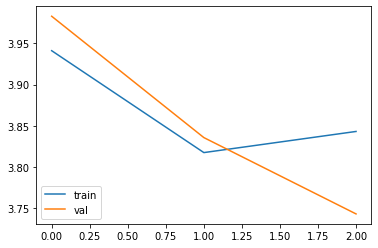

In [10]:
save_root = 'nlp-bot.pt'

#qwer.load(save_root, device)
qwer.fit(
    train=train,
    val=valid,
    epohs=1,
    device=device,
    save_root=save_root
)
qwer.visualiz()
#print('accuracy -', qwer.accuracy(valid, device))

In [13]:
txt = 'я первый раз иду гулять, а ты?'
rat = bot(txt)
print(f'- {txt}')
print(f'- {rat}')

- я первый раз иду гулять, а ты?
- да, я   , а что ты  ,  ,  ,
